<a href="https://colab.research.google.com/github/chrisamz/142-Final-Project/blob/main/mysol_present.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import matplotlib.pyplot as plt

We use the Metropolis Monte Carlo algorithm, which inductively constructs a sequence:

> - Take prior vector $X^{(k)} \in \mathbb R^N$, and integer $0 \le d < N$. Let $e_d$ denote the $d^{th}$ elementary basis vector
$$\begin{matrix}e_d = \left(\right. 0&\dots&0&1&0&\dots&0\left.\right)\\ &&&(d^{th}\text{ dimension})\end{matrix}$$
> - Select $r$ uniformly from
$$- \frac{\Delta}{2} < r < \frac{\Delta}{2}$$
> - Sample a random $a$ uniformly on the unit interval and set $X^{(k+1)} = X^{(k)} + re_d$ if $a < \frac{P(X^{(k)} + r_ed)}{P(X^{(k)})}$ and $X^{(k+1)} = X^{(k)}$ otherwise.
> - Set $d \leftarrow (d + 1) \mod N$ for the next step to use the next dimension.

We only need the changed point $x_k = X_{d}^{(k)}$ in order to sample from the spatial probability distribution $p(x) = |\psi(x)|^2$ given the path probability distribution $P(X) = \exp(-S/\hbar)$ for path action $S$:
- $p(x)$ can be estimated by binning the returned $x_k$.
- $\langle V \rangle$ can be estimated by taking the sample average of the $V(x_k)$.
- $\langle T \rangle$ can be estimated by the Virial Theorem from the sample average of the $\frac{1}{2}x_k V'(x_k)$.
- $\langle E \rangle$ is then $\langle V \rangle + \langle T \rangle$ by linearity of expectation.

## (A) and (B)

In [21]:
def particle_gibbs(V,N,eps,delta=1,x0=None,hbar=1,m=1):
    """ Yeilds values of a sequence generated by Gibbs sampling on the
    heat-bath quantum particle.

    V           function of potential energy
    N           number of substeps
    eps         size of substeps
    
    delta       length of interval for the monte carlo walk step (default: 1)
    x0          initial position, length N array, excluding the x_N = x_0 point
                (default: array of zeros)
    hbar        value of h-bar (default: 1)
    m           value of mass (default: 1)
    """
    if x0 is None:
        x0 = np.zeros(N)
    
    stepdim = 0 # which dimension to sample from next

    tau = N*eps
    const_ke_coeff = -m/(2*eps*hbar) #constant in front of the KE part of the sum
    const_pe_coeff = -eps/hbar       #constant in front of the PE part of the sum

    num_iters = 0
    num_accepts = 0

    while True:
        num_iters += 1
        #new point only along specific dimension
        xold = x0[stepdim]
        xnew = xold + (np.random.rand() - 0.5)*delta
        xleft = x0[(stepdim-1) % N]
        xright = x0[(stepdim+1) % N]
        #subtract old terms and add new terms inside exp
        
        action_diff = (
            const_ke_coeff*((xnew - xleft)**2 - (xold - xleft)**2
                + (xright - xnew)**2 - (xright - xold)**2 )
           +const_pe_coeff*(V(xnew) - V(xold))
        )

        # Pnew/Pold = exp(-tau Enew/hbar)/exp(-tau Eold/hbar) = ...
        if np.random.rand() < np.exp(action_diff):
            x0[stepdim] = xnew
            num_accepts += 1

        yield x0[stepdim],num_accepts/num_iters
        stepdim = (stepdim + 1) % N

Python allows for nice syntax with `yield`. A function with the `yield` keyword can be made into a generator, so we can do something like:

```
def seq():
    a = 0;
    while True:
        yield a
        a += 1

for num in seq():
    print(num)
```

Which outputs the numbers $0,1,2,\dots$ and goes on infinitely.

For our code, we collect the $x_k$ (as in above), bin them by value, and calculate Kinetic and Potential energy, as well as $x_k^2$. To properly estimate the errors, we also bin the energy values and $x_k^2$ so that correlated (sequential) values fall in the same bin. Making a guess on the correlation time, we can give an underestimate on the variance.

In [22]:
def iterate_walker(V,dVdx,N,eps,collect_samples,warm_up,bin_xmin,bin_xmax,bins_array,var_bin_size = 1e6, do_progress_bar = False, x_init = 0):
    KE_bin = np.zeros(round(np.ceil(collect_samples/var_bin_size)))
    PE_bin = np.zeros(round(np.ceil(collect_samples/var_bin_size)))
    x2_bin = np.zeros(round(np.ceil(collect_samples/var_bin_size)))
    cur_binsize = 0; cur_bin = 0
    
    
    bin_count = len(bins_array)
    bindx = (bin_xmax - bin_xmin)/bin_count


    #=====progress bar
    if do_progress_bar:
        progress_bar_num_parts = 100
        print("Progress\n┌" + "─"*progress_bar_num_parts + "┐\n",end="│")
        progress_bar_it = 0
    #=================

    delta = 4 * np.sqrt(eps)
    #current sample
    n = -warm_up
    for xnew,accept_rate in particle_gibbs(V,N,eps,delta=delta,x0=np.zeros(N) + x_init):
        if n < 0: #still in warm up
            n += 1
            continue
        
        if bin_xmin <= xnew and xnew <= bin_xmax:
            bins_array[int(np.floor((xnew-bin_xmin)/bindx))] += 1
        
        n += 1; cur_binsize += 1
        KE_bin[cur_bin] += xnew*dVdx(xnew) / 2
        PE_bin[cur_bin] += V(xnew)
        x2_bin[cur_bin] += xnew**2

        #bin complete?
        if cur_binsize >= var_bin_size:
            cur_bin += 1
            cur_binsize = 0


        #=====progress bar
        if do_progress_bar:
            progress_bar_next = round(progress_bar_num_parts * n/(collect_samples)) - progress_bar_it
            if progress_bar_next > 0:
                print("="*progress_bar_next,end="")
                progress_bar_it += progress_bar_next
        #=================

        if n >= collect_samples:
            break
    
    #combine

    KE_avg = np.sum(KE_bin)/n
    PE_avg = np.sum(PE_bin)/n
    x2_avg = np.sum(x2_bin)/n

    #error estimate on the bin averages
    
    KE_error = np.sum((KE_bin/var_bin_size - KE_avg)**2)/(cur_bin - 1)
    PE_error = np.sum((PE_bin/var_bin_size - PE_avg)**2)/(cur_bin - 1)
    x2_error = np.sum((x2_bin/var_bin_size - x2_avg)**2)/(cur_bin - 1)

    if do_progress_bar:
        print("│")
        print(f"Acceptance rate: {accept_rate}")

    return KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error


#potential function
V = lambda x: x**2/2
dVdx = lambda x: x

#parameters
N = 100; eps = 0.1
tau = N * eps

#suggested by paper
delta = 4 * np.sqrt(eps)

#how many samples to iterate, but throw away
warm_up = 1000 * N

#number of samples to collect
collect_samples = 1000000 * N

#collect x in bins
xmin = -4; xmax = 4; nbins = 100
bindx = (xmax - xmin)/nbins
X_binned = np.zeros(nbins,np.int64)

Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5129273826173826
KE = 0.24610552697572424 ± 0.0002817457215060103
PE = 0.24610552697572424 ± 0.0002817457215060103
 E = 0.4922110539514485 ± 0.0003984486204943927
x^2 = 0.4922110539514485 ± 0.0011269828860240411


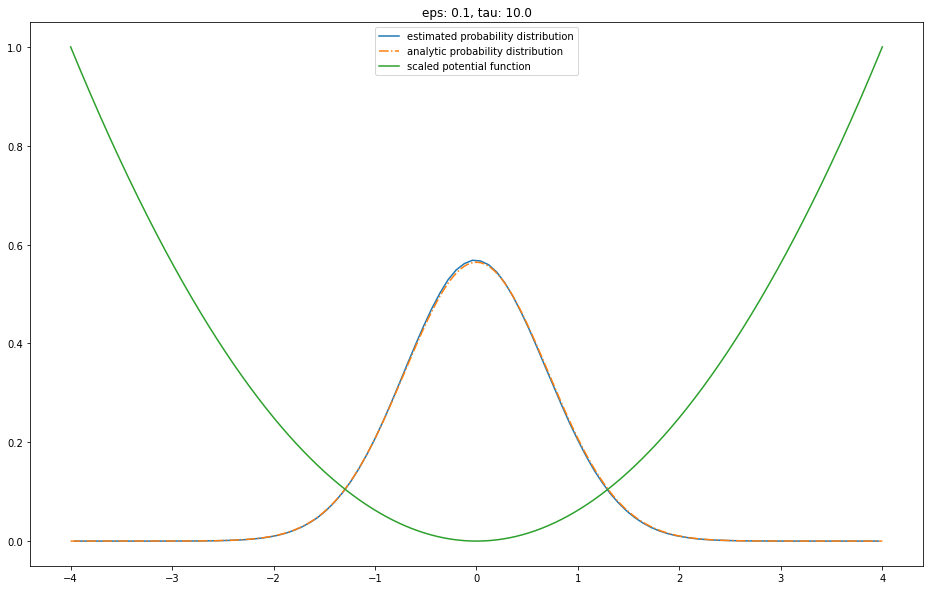

In [23]:
KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error = iterate_walker(V,dVdx,N,eps,collect_samples,warm_up,xmin,xmax,X_binned, do_progress_bar = True)

print(f"KE = {KE_avg} ± {KE_error}")
print(f"PE = {PE_avg} ± {PE_error}")
print(f" E = {KE_avg + PE_avg} ± {np.sqrt(KE_error**2 + PE_error**2)}")
print(f"x^2 = {x2_avg} ± {x2_error}")

plt.figure(figsize=(16,10))
plt.title(f"eps: {eps}, tau: {tau}")
plt.plot(np.linspace(xmin+bindx/2,xmax-bindx/2,nbins),X_binned/sum(X_binned) / bindx,label="estimated probability distribution")
plt.plot(np.linspace(xmin,xmax,1000), (1/np.pi)**0.5 * np.exp(-0.5*np.linspace(xmin,xmax,1000)**2)**2,"-.",label="analytic probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()

In [ ]:
V = lambda x: -2*x**2 + 0.4*x**4 + 2.5
dVdx = lambda x: -4*x + 1.6*x**3

Expected ground state probability density for double well potential from Schrodinger's Equation

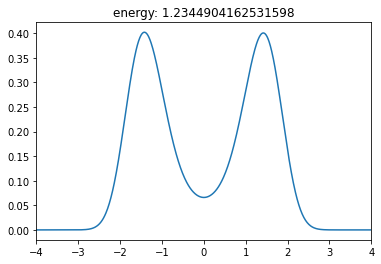

Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5091338061938062
KE = 0.5042749153312853 ± 0.011755810644807652
PE = 0.7456330090428054 ± 0.003554235368754381
 E = 1.2499079243740907 ± 0.012281354688025155
x^2 = 2.006504448622837 ± 0.011916165226632542


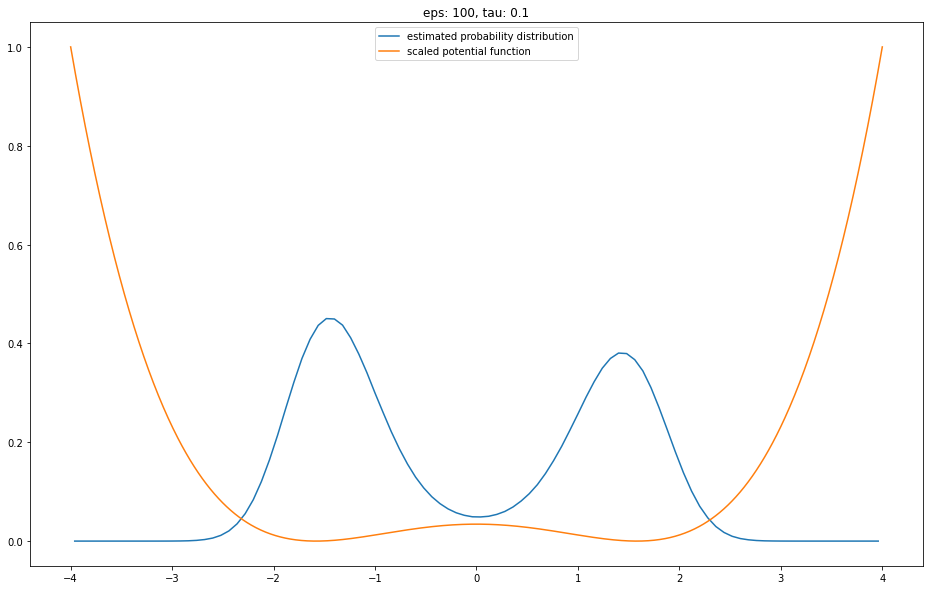

In [ ]:
X_binned = np.zeros(nbins,np.int64) #reset the bins
KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error = iterate_walker(V,dVdx,N,eps,collect_samples,warm_up,xmin,xmax,X_binned, do_progress_bar = True)

print(f"KE = {KE_avg} ± {KE_error}")
print(f"PE = {PE_avg} ± {PE_error}")
print(f" E = {KE_avg + PE_avg} ± {np.sqrt(KE_error**2 + PE_error**2)}")
print(f"x^2 = {x2_avg} ± {x2_error}")

plt.figure(figsize=(16,10))
plt.title(f"eps: {eps}, tau: {tau}")
plt.plot(np.linspace(xmin+bindx/2,xmax-bindx/2,nbins),X_binned/sum(X_binned) / bindx,label="estimated probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()

*Note: Correction to above figure title "eps = 0.1, tau = 10", the same as previous figure

Most of the time, the walker is biased towards one side since we did not run for long enough. One option to deal with it is to use multiple independent walkers and average those. Variances are additive on sums of independent random variables, so we can estimate the error on that mean.

In [ ]:
def multiple_runs(V,dVdx,N,eps,num_runs,samples_per_run,warm_up,var_bin_size = 1e6, do_progress_bar = False):

    #binning for x values
    bin_xmin = -4; bin_xmax = 4; nbins = 200; bindx = (bin_xmax - bin_xmin)/nbins
    bins_array = np.zeros(nbins,np.int64)


    KE_avg = 0; PE_avg = 0
    x2_avg = 0

    KE_errors = np.empty(num_runs)
    PE_errors = np.empty(num_runs)
    x2_errors = np.empty(num_runs)

    for current_run in range(num_runs):

        init_pos = (np.random.rand()-0.5) * 4
        KE, KE_error, PE, PE_error, x2, x2_error = iterate_walker(V,dVdx,N,eps,samples_per_run,warm_up,bin_xmin,bin_xmax,bins_array, do_progress_bar = True,x_init = init_pos)
        
        KE_errors[current_run] = KE_error
        PE_errors[current_run] = PE_error
        x2_errors[current_run] = x2_error

        KE_avg = (KE_avg * (current_run) + KE)/(current_run + 1)
        PE_avg = (PE_avg * (current_run) + PE)/(current_run + 1)
        x2_avg = (x2_avg * (current_run) + x2)/(current_run + 1)
        
    #standard deviations
    KE_sd = np.sqrt(np.sum(KE_errors))/num_runs
    PE_sd = np.sqrt(np.sum(PE_errors))/num_runs
    x2_sd = np.sqrt(np.sum(x2_errors))/num_runs

    return KE_avg, KE_sd, PE_avg, PE_sd, x2_avg, x2_sd, np.linspace(bin_xmin+bindx, bin_xmax-bindx, nbins), bins_array


Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5104509090909091
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


====================================================================================================│
Acceptance rate: 0.5091672727272727
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5093654545454546
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5095827272727272
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5092672727272727
Progress
┌───────────────────────────────────────────────────────────────────────────────────────────────────

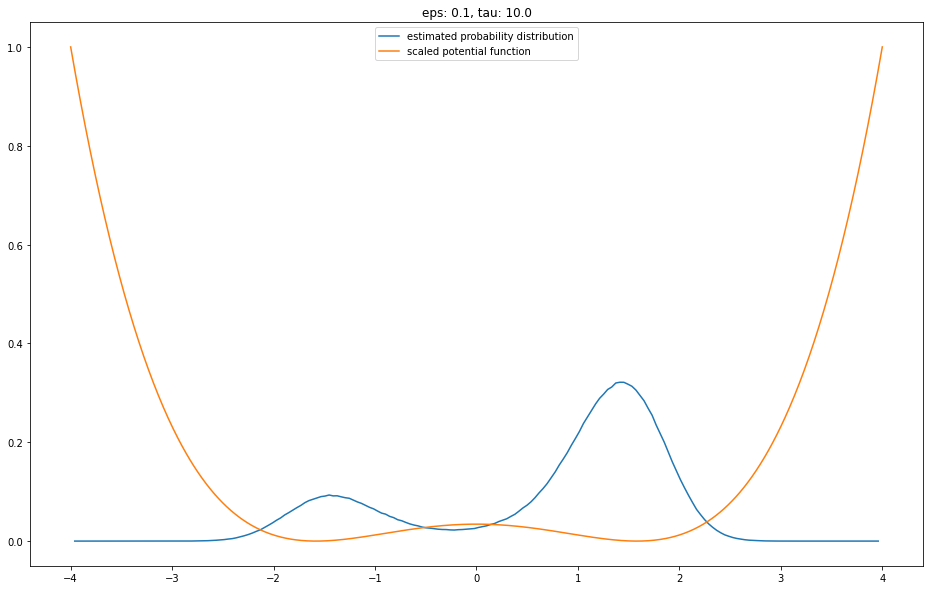

In [ ]:
#number of samples to collect
samples_per_run = 10000 * N
N = 100; eps = 0.1
tau = N * eps
#use multiple independent walkers
num_runs = 10

KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error, binX, bins = multiple_runs(V,dVdx,N,eps,num_runs,samples_per_run,warm_up,var_bin_size = 1e5, do_progress_bar = False)

print(f"KE = {KE_avg} ± {KE_error}")
print(f"PE = {PE_avg} ± {PE_error}")
print(f" E = {KE_avg + PE_avg} ± {np.sqrt(KE_error**2 + PE_error**2)}")
print(f"x^2 = {x2_avg} ± {x2_error}")

plt.figure(figsize=(16,10))
plt.title(f"eps: {eps}, tau: {tau}")
plt.plot(binX,bins/sum(bins) / bindx,label="estimated probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()

## (C)

We take the limit of some large $\tau$ in order to suppress the probability density $\rho_n$ of other energy levels besides the ground state $\rho_0$. This is due to the first term in the discretized path summation dominating all the other terms so that $\rho_0$ ~ 1.

$$
∫ Κ(x,\tau;x,0) \,dx = ∑_n \exp\bigg[{\frac{-E_n \tau}{\hbar}}\bigg]
$$

This method of moving from the real plane onto the complex plane allows us to easily point out the ground state energy, but once we drop to lower $\tau$ values, the contributions from probability densities of other energy levels become significant.

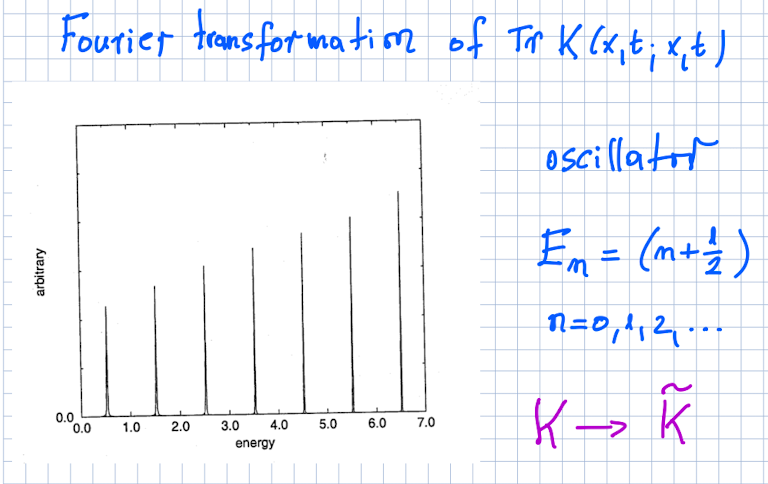

Above shows image of simple harmonic oscillator energy levels in imaginary time

Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5139171528471529
KE = -0.5236206137931573 ± 0.18736838728501373
PE = 1.671739209936759 ± 0.6423251520198147
 E = 1.1481185961436018 ± 0.6690952947608173
x^2 = 0.5664504831666521 ± 0.40373346905154256


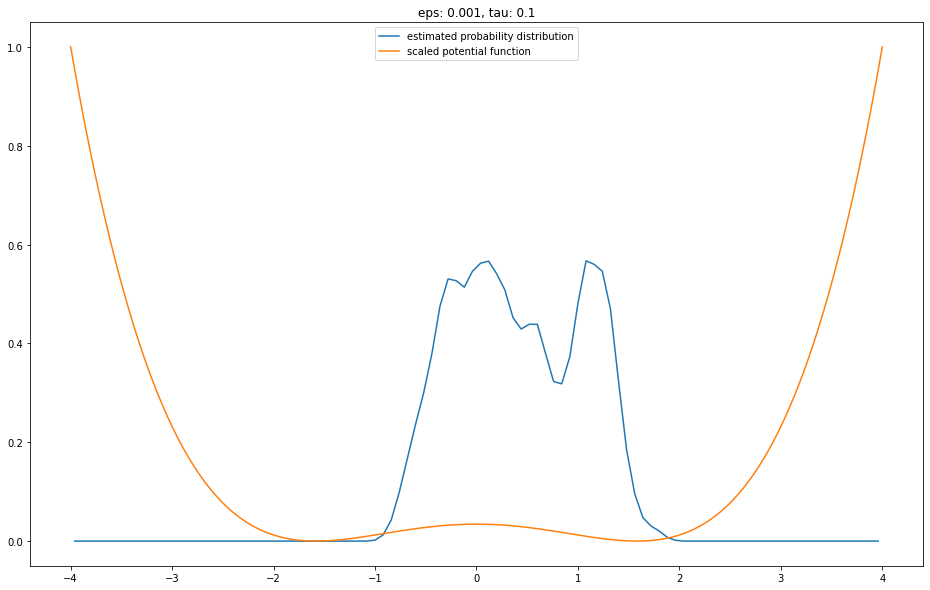

In [25]:
V = lambda x: -2*x**2 + 0.4*x**4 + 2.5
dVdx = lambda x: -4*x + 1.6*x**3
#parameters
N = 100; eps = 0.001
tau = N * eps

X_binned = np.zeros(nbins,np.int64) #reset the bins
KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error = iterate_walker(V,dVdx,N,eps,collect_samples,warm_up,xmin,xmax,X_binned, do_progress_bar = True)

print(f"KE = {KE_avg} ± {KE_error}")
print(f"PE = {PE_avg} ± {PE_error}")
print(f" E = {KE_avg + PE_avg} ± {np.sqrt(KE_error**2 + PE_error**2)}")
print(f"x^2 = {x2_avg} ± {x2_error}")

plt.figure(figsize=(16,10))
plt.title(f"eps: {eps}, tau: {tau}")
plt.plot(np.linspace(xmin+bindx/2,xmax-bindx/2,nbins),X_binned/sum(X_binned) / bindx,label="estimated probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()

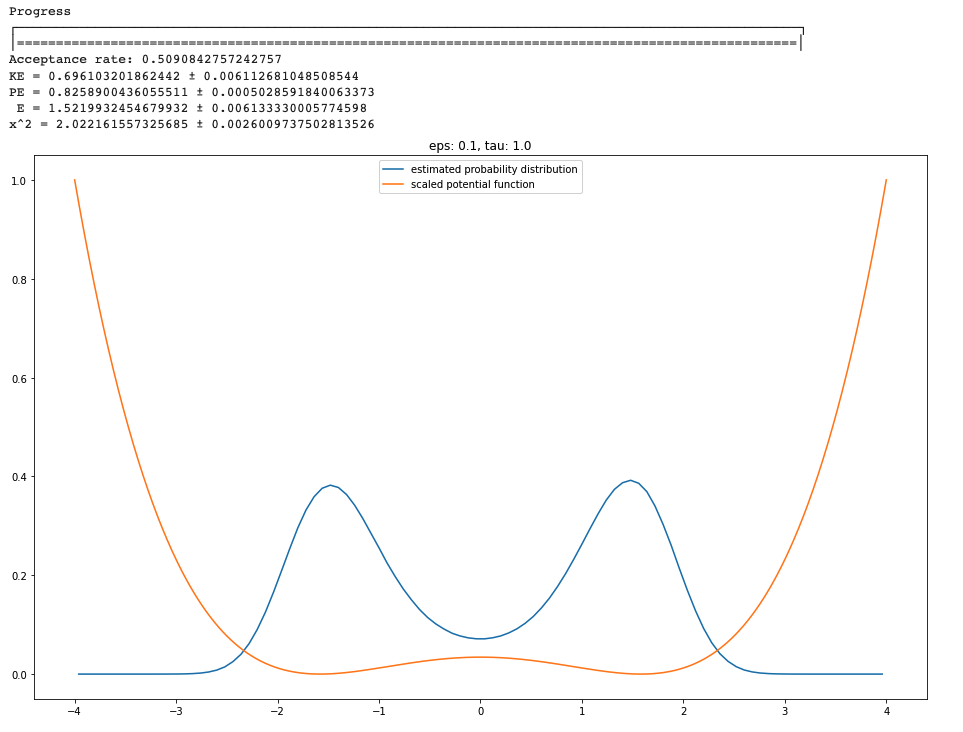

Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.50897
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.51028
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.50711
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5102
Progress
┌───────────────────────────────

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


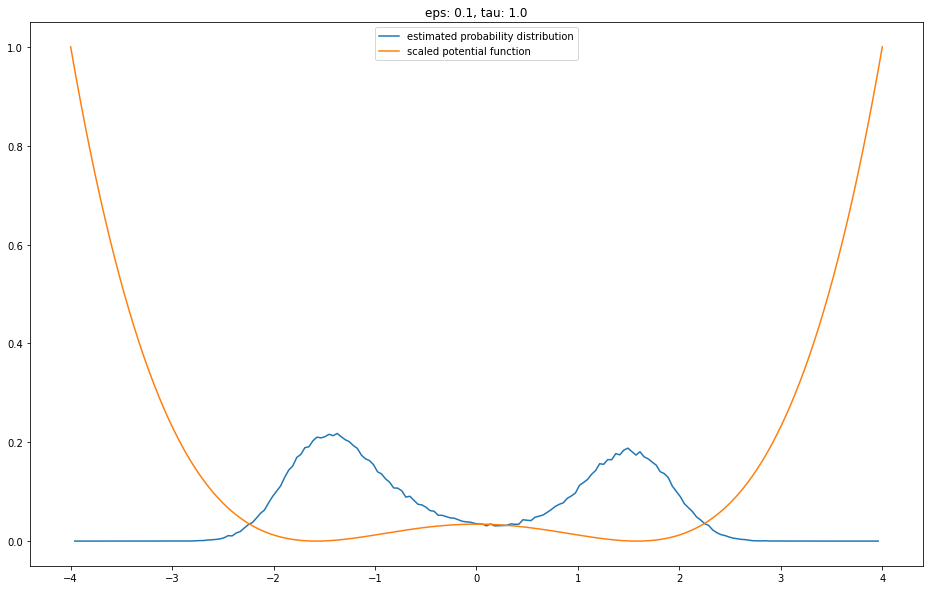

In [ ]:
#parameters
N = 10; eps = 0.1
tau = N * eps

#number of samples to collect
samples_per_run = 10000 * N

#use multiple independent walkers
num_runs = 5

KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error, binX, bins = multiple_runs(V,dVdx,N,eps,num_runs,samples_per_run,warm_up,var_bin_size = 1e5, do_progress_bar = False)

print(f"KE = {KE_avg} ± {KE_error}")
print(f"PE = {PE_avg} ± {PE_error}")
print(f" E = {KE_avg + PE_avg} ± {np.sqrt(KE_error**2 + PE_error**2)}")
print(f"x^2 = {x2_avg} ± {x2_error}")

plt.figure(figsize=(16,10))
plt.title(f"eps: {eps}, tau: {tau}")
plt.plot(binX,bins/sum(bins) / bindx,label="estimated probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()

This is why the figure does not look like any one stationary state of the electron in a double well potential system. Here, $\tau = 1$, which is a magnitude smaller than previous examples.


Below is the simulation results if following project 1's prompt of considering when $\tau^{-1} = 5\hbar\omega$, or $\tau = 1/5$ in our units, where $\hbar = 1, \omega = 1$

Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5088133333333333
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5087666666666667
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.50872
Progress
┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│====================================================================================================│
Acceptance rate: 0.5094866666666666
Progres

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


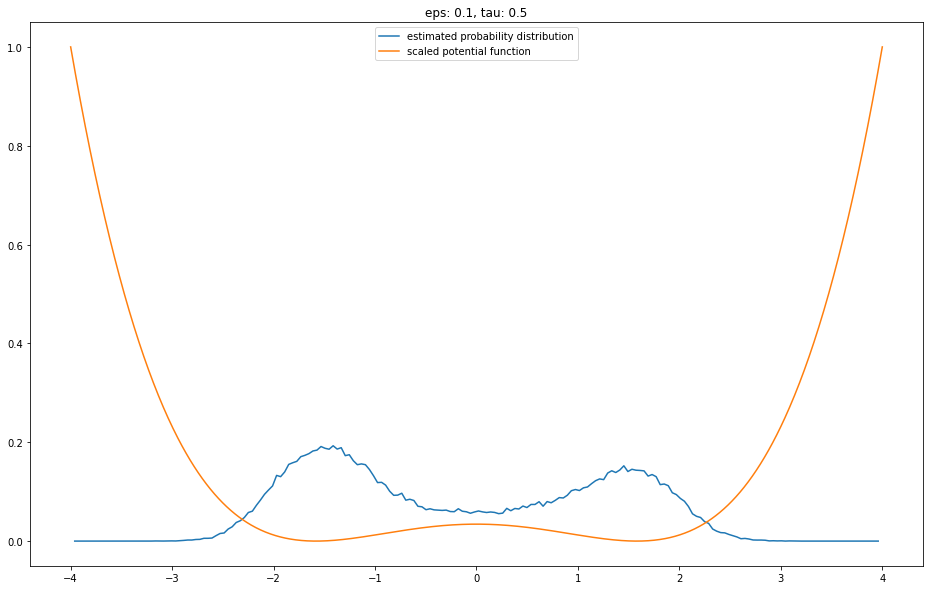

In [ ]:
#parameters
N = 2; eps = 0.1
tau = N * eps

#number of samples to collect
samples_per_run = 10000 * N

#use multiple independent walkers
num_runs = 5

KE_avg, KE_error, PE_avg, PE_error, x2_avg, x2_error, binX, bins = multiple_runs(V,dVdx,N,eps,num_runs,samples_per_run,warm_up,var_bin_size = 1e5, do_progress_bar = False)

print(f"KE = {KE_avg} ± {KE_error}")
print(f"PE = {PE_avg} ± {PE_error}")
print(f" E = {KE_avg + PE_avg} ± {np.sqrt(KE_error**2 + PE_error**2)}")
print(f"x^2 = {x2_avg} ± {x2_error}")

plt.figure(figsize=(16,10))
plt.title(f"eps: {eps}, tau: {tau}")
plt.plot(binX,bins/sum(bins) / bindx,label="estimated probability distribution")
plt.plot(np.linspace(xmin,xmax,1000),V(np.linspace(xmin,xmax,1000))/V(xmin),label="scaled potential function")
plt.legend()
plt.show()

### (D)

In [ ]:
D.)

 # Make tau very large
 """
 xrand = random.uniform(a,b,N) --> can be used instead of for loop, will yield ramd number
 from 0 to N and integrate within the limits a to b  
 """

 """ 
 #Nested for loop can in theory circumvent the check method for mcmc, instead of
      integral variable could implement shm**2, since the problem is asking for the 
      probability distribution was thinking of using the areas.append function in python
      to show the distribution of the outputs as a probability distibution. 

  for i in range(N):
    xrand = np.zeros(N)

    for i in range(lend(xrand)):
      xrand[i] = random.uniform(a,b)
      integral = 0.0

      for i in range(N):
        integral+= func(xrand[i])
      
      answer = (b-a)/float(N)*integral
      #areas.append gives the distribution of the answers when choosing random 
      inputs, should show a normal distibution instead of running a separate for loop

      areas.append(answer)

(This is code for the classical potential which can be adapted to the MCMC code)
      N = 2000 #number of samples
dy = 1/N
y = np.linspace(0, 1, N+1)

def mL2V(y):  #defining classical potential
    return 1000*(y-1/2)**2
V = mL2V(y)
d = 1/dy**2 + mL2V(y)[1:-1]
e = -1/(2*dy**2) * np.ones(len(d)-1). 
w, v =  eigh_tridiagonal(d, e)    #gives the eigenvectors of the matrix above


 """
#The tau towards infinity would crush the other states and would


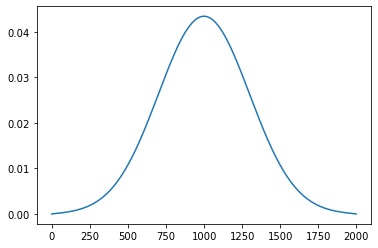